# Produce lifetime XY map and write a dst corrected by lifetime and energy scale

### Run number

In [1]:
import os

run_number          = 6205

input_dst_filename  = os.path.expandvars(f"$IC_DATA/dst/dst_{run_number}.h5")
lt_filename         = os.path.expandvars(f"$IC_DATA/maps/lt_{run_number}.h5")
output_dst_filename = os.path.expandvars(f"$IC_DATA/ldst/dst_{run_number}.h5")

print(f"run number  = {run_number}")
print(f"input dst   = {input_dst_filename}")
print(f"lt_filename ={lt_filename}")
print(f"output dst  ={output_dst_filename}")

run number  = 6205
input dst   = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6205.h5
lt_filename =/Users/jjgomezcadenas/Projects/ICDATA/maps/lt_6205.h5
output dst  =/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6205.h5


### Notebook configuration

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [4]:
import os
import time
import datetime
import collections
import glob
import matplotlib.dates  as md
import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
import invisible_cities.reco    .corrections    as corrf

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [5]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import kr_event
from core.kr_types import kr_times_ranges_and_bins
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from core.kr_types import DstEvent, NevtDst

from   invisible_cities.evm  .ic_containers  import Measurement

In [6]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [7]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [8]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [9]:
from typing      import NamedTuple

In [10]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [11]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Fri Jul 13 20:56:01 2018


### Local data classes

In [12]:
class Ndst(NamedTuple):
    full  : int
    fid   : int
    core  : int
    hcore : int


class EffDst(NamedTuple):
    full  : float
    fid   : float
    core  : float
    hcore : float

### Read data

In [13]:
#dst = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
dst            = dstf.load_dst(input_dst_filename, "DST", "Events")

In [14]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 3133168


In [15]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [16]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   40,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [17]:
print(krRanges, krNBins)

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), T=(1531308400.6990001, 1531468235.187)) KrNBins(Z=10, XY=40, E=50, S1=20, Q=25, T=44)


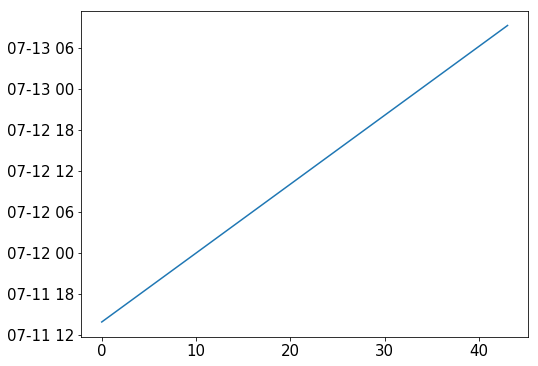

In [18]:
plt.plot(krTimes.timeStamps)

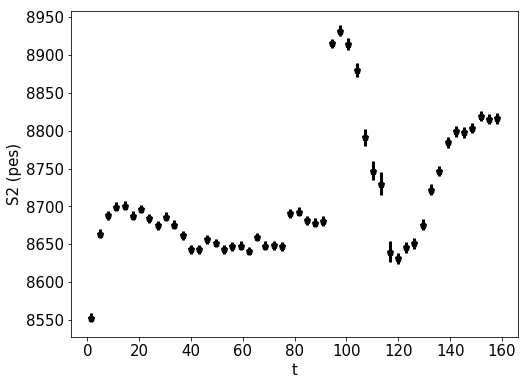

In [39]:
T   =(dst.time - dst.time.min()) 
tt = T.values/1000
t, e, eu = fitf.profileX(tt, dst.S2e, 50)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('S2 (pes)')

### Define time regions:

1. Prior to stop circulation, leaky system (10 to 80)
2. Circulation stopped (80 to 120)
3. Circulation restored, system not leaky

In [40]:
dst1 = dst[in_range(tt, 10, 80)]
dst2 = dst[in_range(tt, 80, 120)]
dst3 = dst[in_range(tt, 120, 160)]

In [46]:
def plot_time_stamps(dst, ts, tbins, tranges, figsize=(6,6)):
    xfmt = md.DateFormatter('%d-%m %H:%M')
    fig = plt.figure(figsize=figsize)
    x, y, yu = fitf.profileX(dst.time, dst.S2e, tbins, tranges)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.xaxis.set_major_formatter(xfmt)
    plt.errorbar(ts, y, yu, fmt="kp", ms=7, lw=3)
    plt.xlabel('date')
    plt.ylabel('S2 (pes)')
    plt.xticks( rotation=25 )

def plotT(T, dst):
    tt = T.values/1000
    t, e, eu = fitf.profileX(tt, dst.S2e, 50)
    plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
    plt.xlabel('t')
    plt.ylabel('S2 (pes)')
    
def plot_time_regions(dsts):
    fig = plt.figure(figsize=(10,10))
    for i, dst in enumerate(dsts):
        ax = fig.add_subplot(3, 1, i+1)
        T   =(dst.time - dst.time.min()) 
        plotT(T, dst)
    

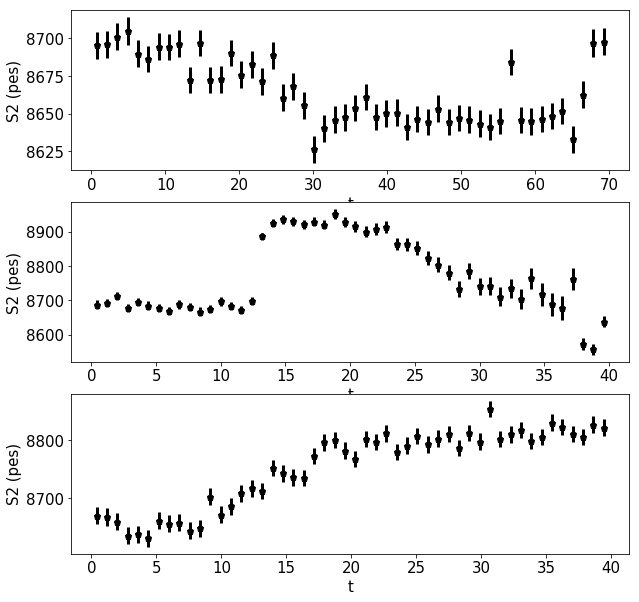

In [42]:
plot_time_regions((dst1, dst2, dst3))

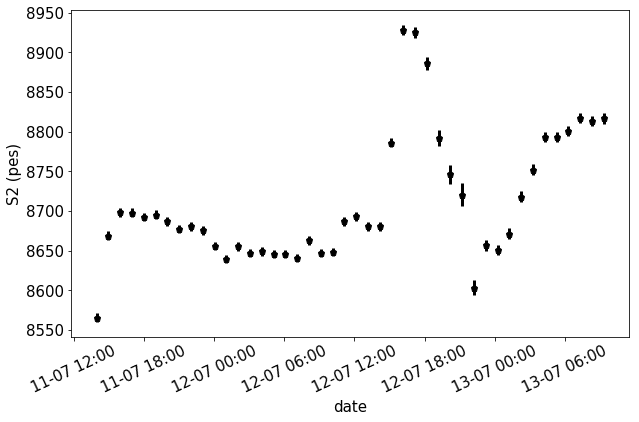

In [48]:
plot_time_stamps(dst, krTimes.timeStamps, krNBins.T, krRanges.T, figsize=(10,6))

### Fiducial volumes

In [25]:
R_full   = 200
R_fid    = 150
R_core   = 100
R_hcore  =  50
print(f" Rfull : {R_full}: Rfiducial : {R_fid}: Rcore = {R_core} Rhcore = {R_hcore} ")

 Rfull : 200: Rfiducial : 150: Rcore = 100 Rhcore = 50 


In [49]:
def fiducial_volumes(dst):
    dst_full   = dst[dst.R < R_full]
    dst_fid    = dst[dst.R < R_fid]
    dst_core   = dst[dst.R < R_core]
    dst_hcore  = dst[dst.R < R_hcore]

    n_dst  = len(dst)

    ndst = Ndst(full  = len(dst_full), 
            fid   = len(dst_fid), 
            core  = len(dst_core), 
            hcore = len(dst_hcore))

    effdst = EffDst(full  = ndst.full  / n_dst, 
                fid   = ndst.fid   / n_dst, 
                core  = ndst.core  / n_dst, 
                hcore = ndst.hcore / n_dst)
    kdst= DstEvent(full  = kr_event(dst_full),
               fid   = kr_event(dst_fid),
               core  = kr_event(dst_core),
               hcore = kr_event(dst_hcore))
    return kdst

In [50]:
kdst= fiducial_volumes(dst)

### Event distribution

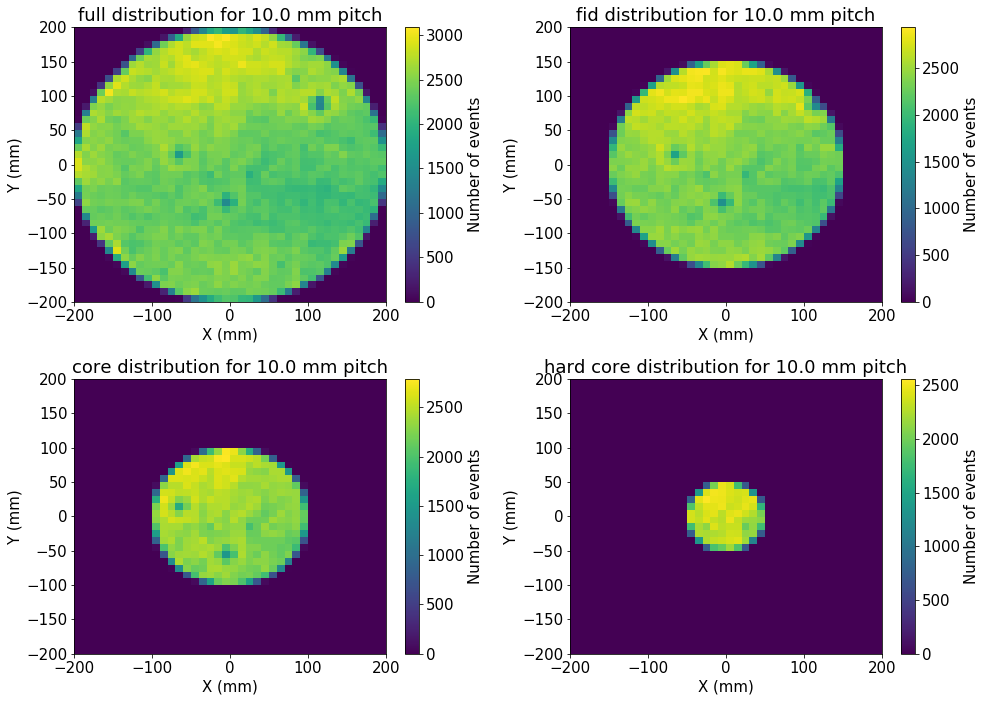

In [51]:
nEvt = krp.plot_xy_density(kdst, krBins)

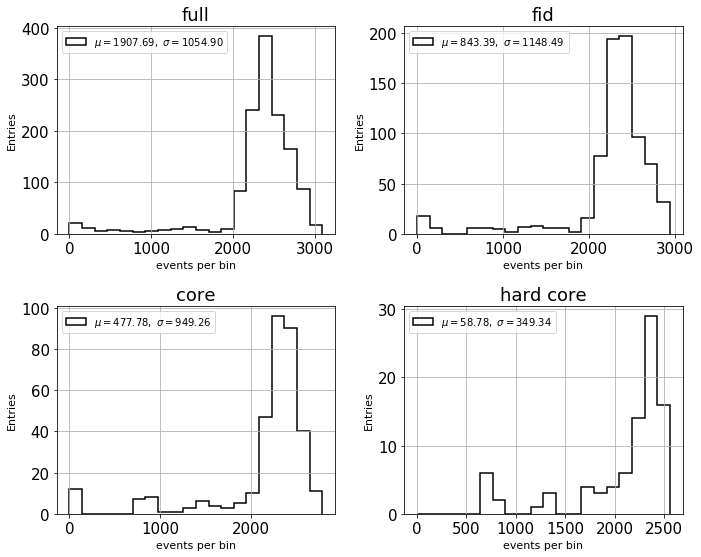

In [52]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

In [68]:
kdst1= fiducial_volumes(dst1)

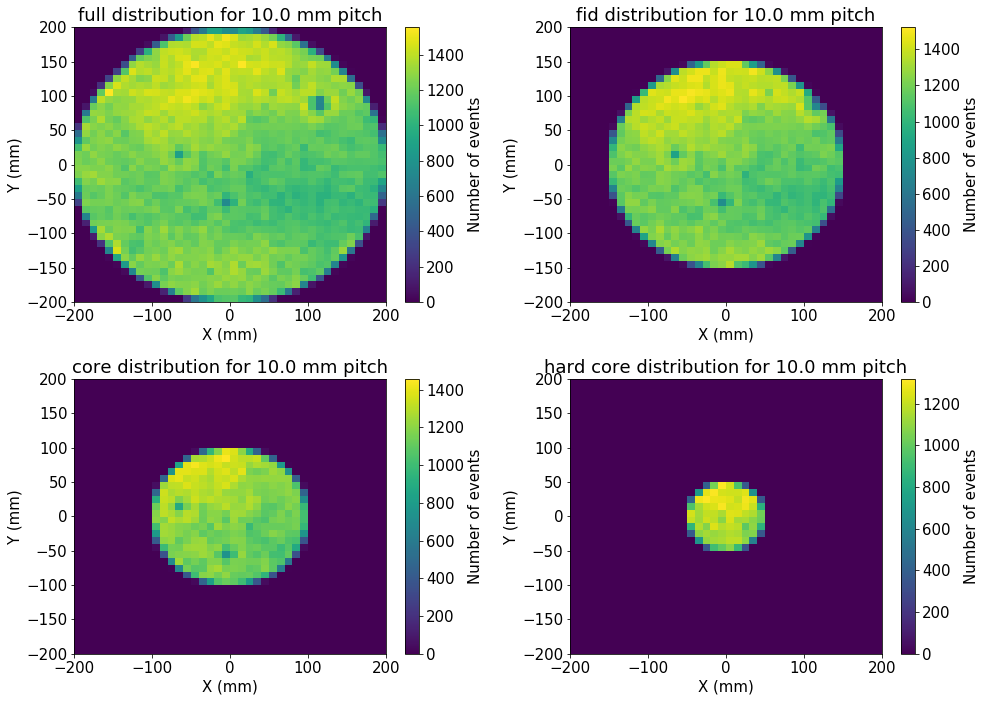

In [69]:
nEvt1 = krp.plot_xy_density(kdst1, krBins)

In [70]:
kdst2= fiducial_volumes(dst2)

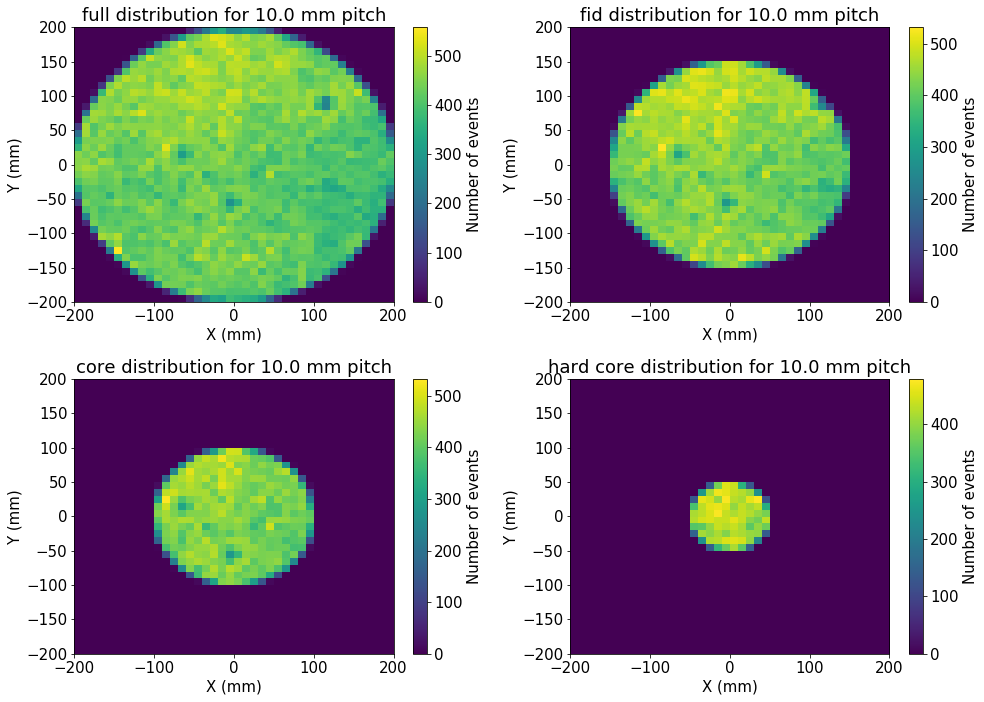

In [71]:
nEvt2 = krp.plot_xy_density(kdst2, krBins)

In [72]:
kdst3= fiducial_volumes(dst3)

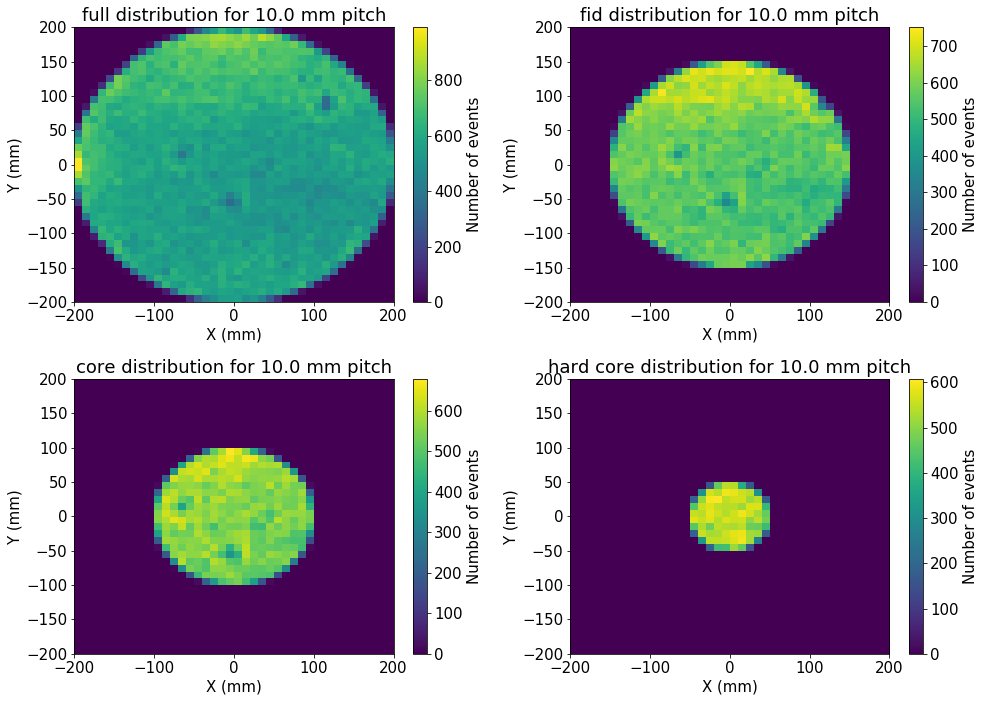

In [73]:
nEvt3 = krp.plot_xy_density(kdst3, krBins)

### Evolution of S12 with time full

In [74]:
krTimes1, krRanges1, krNBins1, krBins1 = kr_times_ranges_and_bins(dst1,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   40,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)
krTimes2, krRanges2, krNBins2, krBins2 = kr_times_ranges_and_bins(dst2,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   40,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)
krTimes3, krRanges3, krNBins3, krBins3 = kr_times_ranges_and_bins(dst3,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   40,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

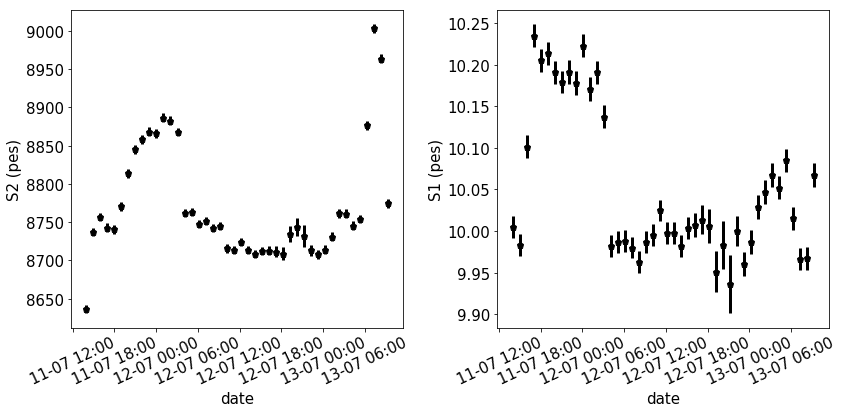

In [75]:
krf.s12_time_profile(kdst.full, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

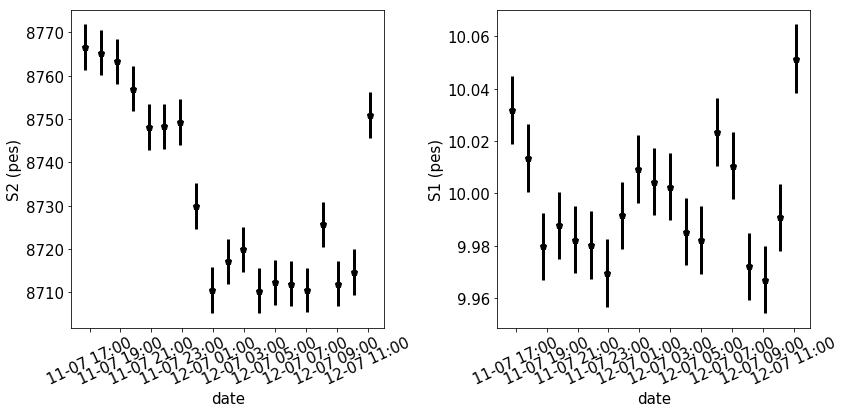

In [76]:
krf.s12_time_profile(kdst1.full, krNBins1.T, krRanges1.T, krTimes1.timeStamps, figsize=(12,6))

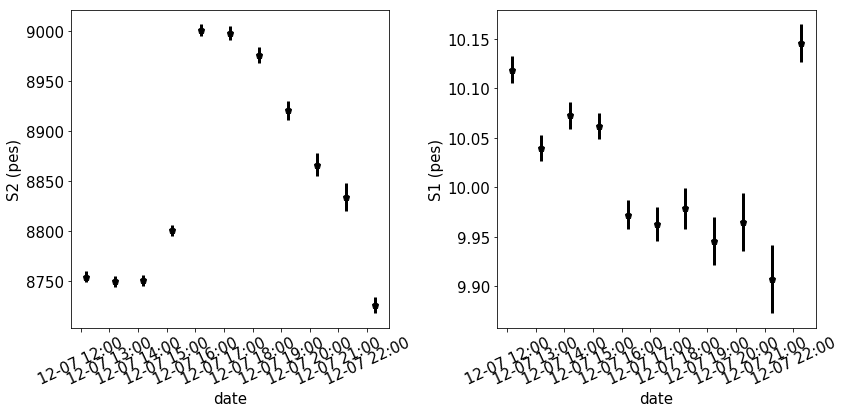

In [77]:
krf.s12_time_profile(kdst2.full, krNBins2.T, krRanges2.T, krTimes2.timeStamps, figsize=(12,6))

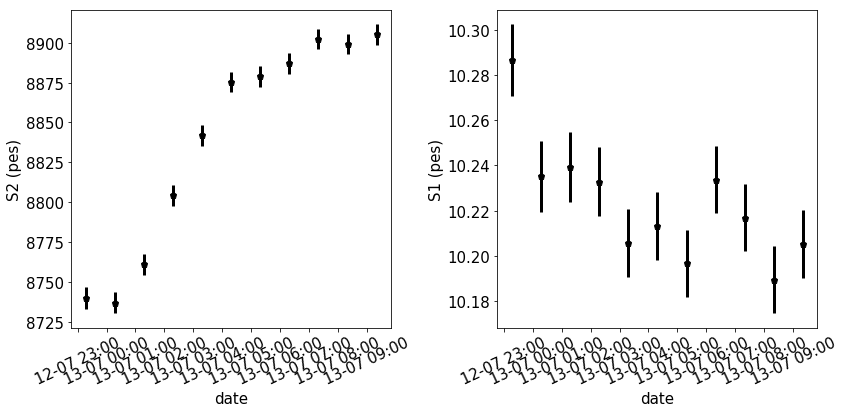

In [78]:
krf.s12_time_profile(kdst3.full, krNBins3.T, krRanges3.T, krTimes3.timeStamps, figsize=(12,6))

In [79]:
def s1_s2_rz_cut(dst, rmax=200, zmin=0, zinterval=600):
    
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    sel = (dst.R < rmax) & (in_range(dst.Z, zmin, zmin + zinterval))
    
    plt.axes(ax[0])
    
    ax[0].set_xlabel("S2 (pes)",fontsize = 11)
    ax[0].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[0].hist(dst.S2e[sel],
                             bins= krNBins.E,
                             range=krRanges.E,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    #x = shift_to_bin_centers(edges)
    
    #seed = np.max(y), x[np.argmax(y)], np.std(y)
    #f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=[x[np.argmax(y)]-1000,x[np.argmax(y)]+1000])
    #ax[0].plot(x, f.fn(x), 'r')
    #ax[0].text(4000, 0.9*np.max(y), f'R = {100*f.values[2]*2.35/f.values[1]:.2f}%')
    
    ax[1].set_xlabel("S1 (pes)",fontsize = 11)
    ax[1].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[1].hist(dst.S1e[sel],
                             bins= krNBins.S1,
                             range=krRanges.S1,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    ax[2].hist2d(dst.S1e[sel], dst.S2e[sel], 100, [[0, 30],[2000, 15000]])
    ax[2].set_xlabel('S1 energy (pes)')
    ax[2].set_ylabel('S2 energy (pes)')
    fig.tight_layout()

In [80]:
w = interactive(s1_s2_rz_cut, dst=fixed(dst), rmax=(0, 200, 10), zmin=(0,600), zinterval=(0,600))
display(w)

interactive(children=(IntSlider(value=200, description='rmax', max=200, step=10), IntSlider(value=0, description='zmin', max=600), IntSlider(value=600, description='zinterval', max=600), Output()), _dom_classes=('widget-interact',))

### S2 vs Z

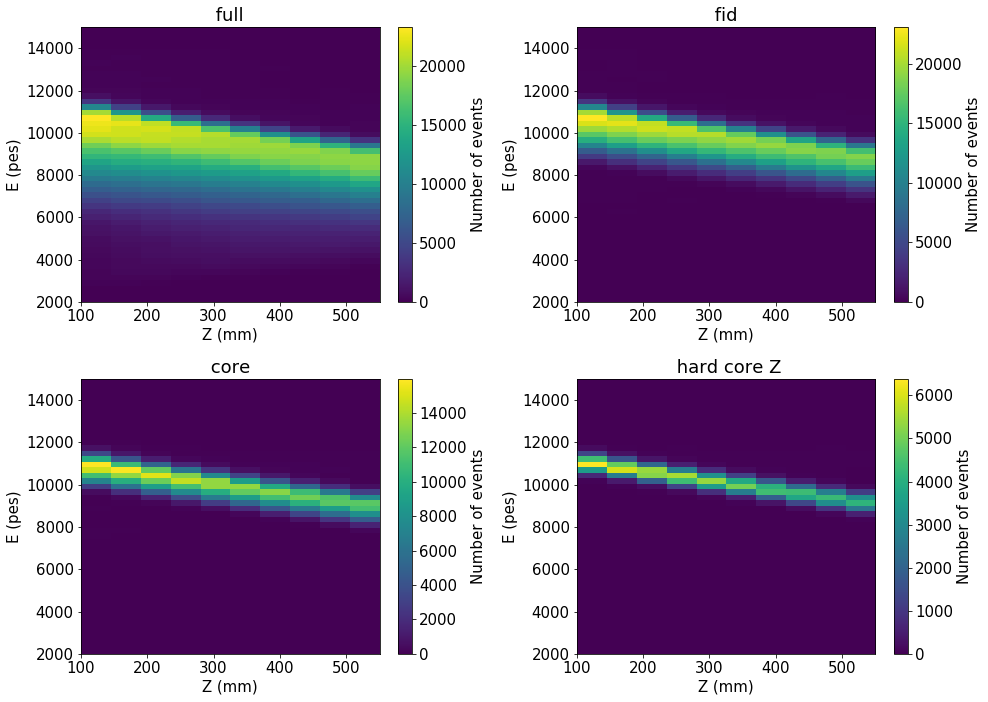

In [81]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

### Fit lifetime in hard core for the three times regions

 E (z=0) = 11564.002971169264 +-3.258473511945637 
 LT      = -2282.8714056453546 +-4.795232477207757 
 chi2    = 2.299749594954811 


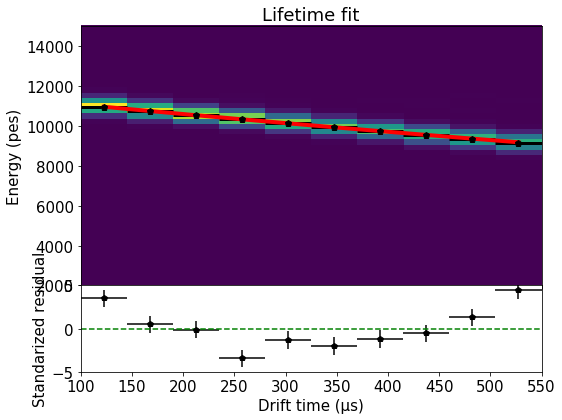

In [82]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst1.hcore, krNBins1, krBins1, krRanges1, xyr)
krf.print_fit(kf)

 E (z=0) = 11639.77129363066 +-7.314286765979207 
 LT      = -2250.271628414798 +-9.900110308737721 
 chi2    = 1.0564017980948481 


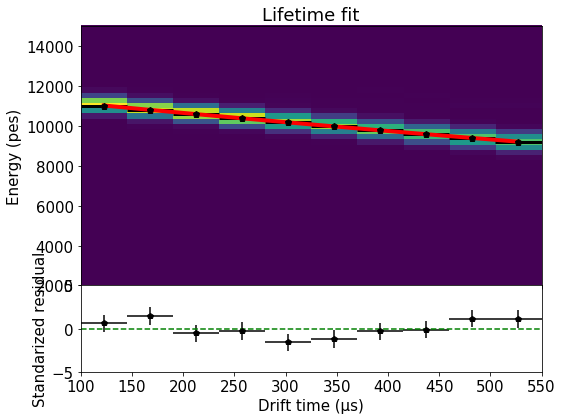

In [83]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst2.hcore, krNBins2, krBins2, krRanges2, xyr)
krf.print_fit(kf)

 E (z=0) = 11577.53433393022 +-12.780667832919317 
 LT      = -2541.46218169334 +-20.110162974024984 
 chi2    = 0.8091722559062794 


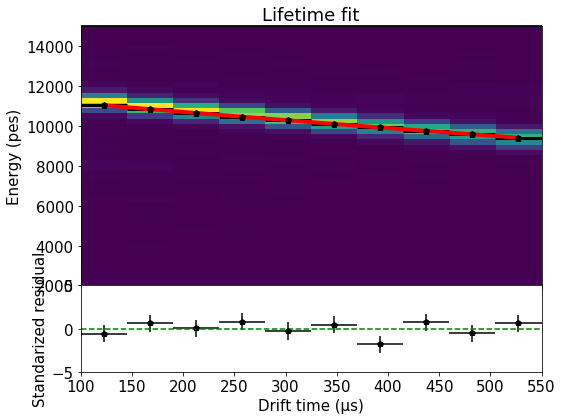

In [84]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst3.hcore, krNBins3, krBins3, krRanges3, xyr)
krf.print_fit(kf)

### Fit lifetime in core in the three regions

 E (z=0) = 11311.481220630258 +-2.2981266823316533 
 LT      = -2257.4602550766003 +-3.248958674088283 
 chi2    = 2.8108326617218165 


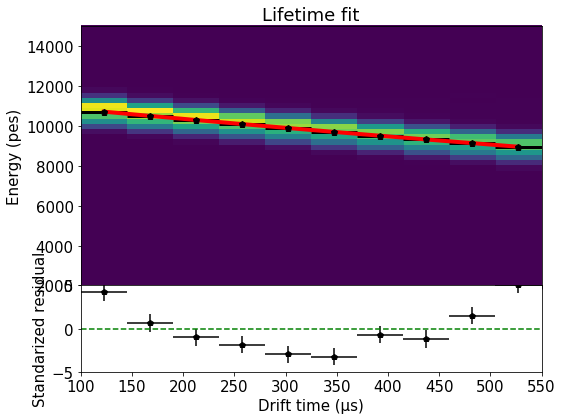

In [85]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst1.core, krNBins1, krBins1, krRanges1, xyr)
krf.print_fit(kf)

 E (z=0) = 11375.631040809618 +-4.562334716876972 
 LT      = -2242.008099900311 +-6.102309191448456 
 chi2    = 1.6561684135766535 


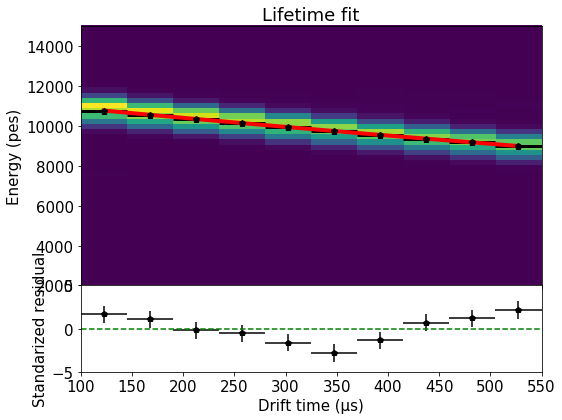

In [86]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst2.core, krNBins2, krBins2, krRanges2, xyr)
krf.print_fit(kf)

 E (z=0) = 11340.294679735742 +-6.711743435921466 
 LT      = -2468.3552829013265 +-10.342601048778745 
 chi2    = 0.7723804012040962 


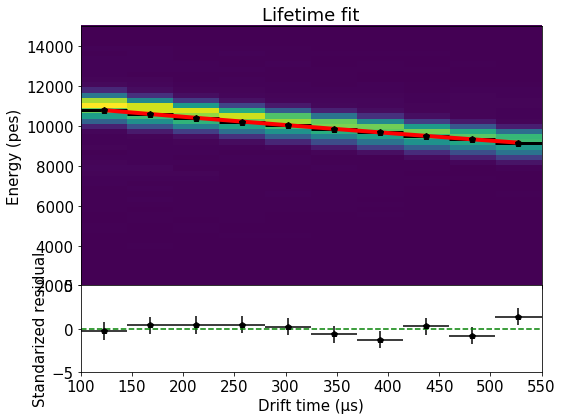

In [87]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst3.core, krNBins3, krBins3, krRanges3, xyr)
krf.print_fit(kf)

### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11111.987945878363 +-6.758537038090506 
 LT      = -2333.6920695296985 +-10.194720137734677 
 chi2    = 1.864551600210485 
 E (z=0) = 10167.38182397898 +-7.499780784333931 
 LT      = -2092.9624910810567 +-10.111166735811487 
 chi2    = 1.5031915541139511 
 E (z=0) = 9802.732728993622 +-7.7075771320408855 
 LT      = -2083.0767910867844 +-10.655872811954849 
 chi2    = 0.9718153881448363 
 E (z=0) = 10237.006245843151 +-7.776463992873572 
 LT      = -2310.6341632732815 +-12.801477548575626 
 chi2    = 1.130173700633715 


[None, None, None, None]

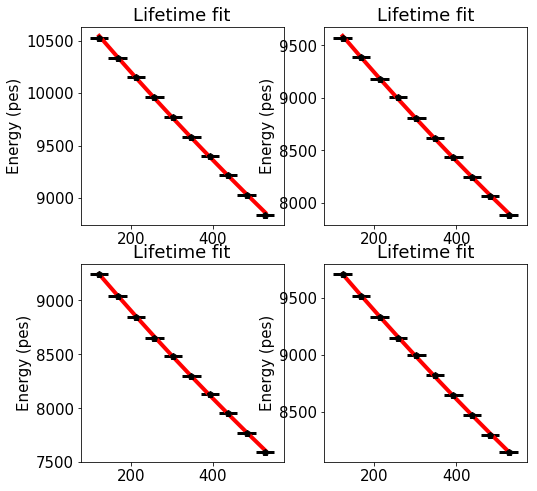

In [88]:
KF = krf.lifetimes_in_XYRange(kdst1.fid, krNBins1, krBins1, krRanges1, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11186.518988991389 +-18.460790629657744 
 LT      = -2317.5087530702917 +-25.456454670057155 
 chi2    = 1.6038140903672273 
 E (z=0) = 10216.335077632468 +-16.174630834080467 
 LT      = -2185.475099667907 +-22.782571656952463 
 chi2    = 0.9481032434804755 
 E (z=0) = 9889.859321043363 +-16.702755795886116 
 LT      = -2124.752726367893 +-24.16850180401969 
 chi2    = 0.9355229899020768 
 E (z=0) = 10329.108765744166 +-14.638947188522188 
 LT      = -2224.6962183342844 +-22.697587073948604 
 chi2    = 0.9839015903661152 


[None, None, None, None]

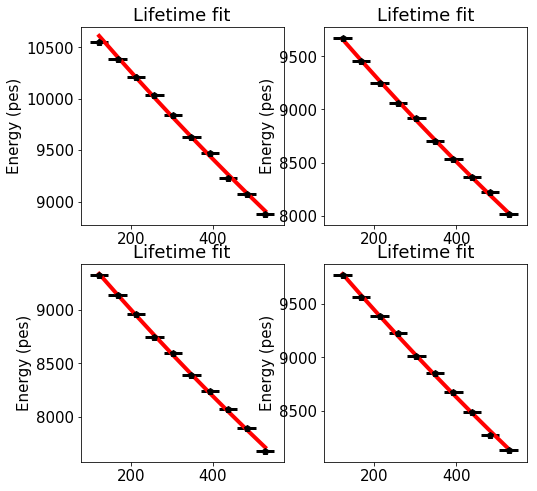

In [89]:
KF = krf.lifetimes_in_XYRange(kdst2.fid, krNBins2, krBins2, krRanges2, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11163.366973492411 +-24.845200770766763 
 LT      = -2517.6308741086177 +-39.12686450264911 
 chi2    = 0.9799906511664443 
 E (z=0) = 10242.123116226225 +-26.29537768369262 
 LT      = -2245.703876492218 +-36.00519545741306 
 chi2    = 0.4117230084643478 
 E (z=0) = 9963.985428190479 +-24.8004870978011 
 LT      = -2107.332552091237 +-32.788263186591834 
 chi2    = 0.7335598049598304 
 E (z=0) = 10344.505768209887 +-23.728252367379234 
 LT      = -2393.1521943409284 +-38.76351545897609 
 chi2    = 0.8203463926661787 


[None, None, None, None]

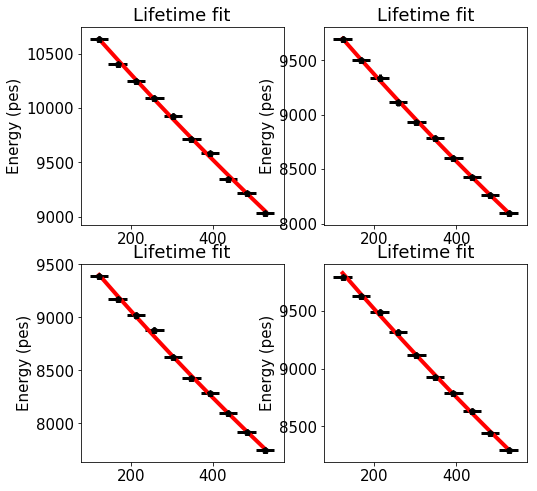

In [90]:
KF = krf.lifetimes_in_XYRange(kdst3.fid, krNBins3, krBins3, krRanges3, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

### Fit low and hig regions

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9538.914986381847 +-4.988892037347069 
 LT      = -1982.6731488889227 +-6.823947996960749 
 chi2    = 1.2473311914633844 
 E (z=0) = 10891.456895246341 +-4.508750651797516 
 LT      = -2271.5468377620623 +-6.584906158168943 
 chi2    = 1.552225195583338 


[None, None]

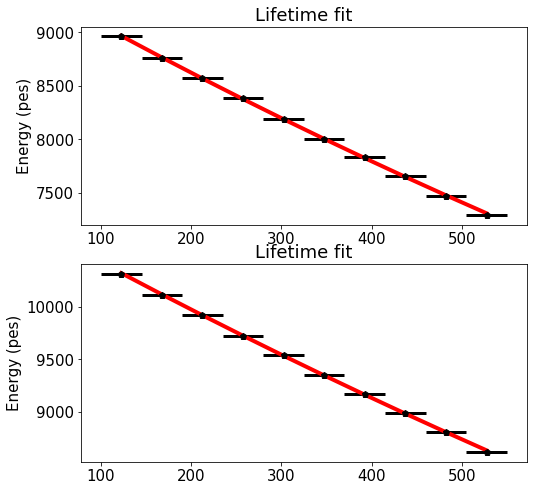

In [91]:
KF = krf.lifetimes_in_XYRange(kdst1.fid, krNBins1, krBins1, krRanges1, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9639.759242795633 +-13.32606817657517 
 LT      = -2044.2655605040386 +-17.483273785805174 
 chi2    = 0.8577412899661481 
 E (z=0) = 10973.83752427676 +-8.245954616121379 
 LT      = -2223.5165565513903 +-11.24044299318465 
 chi2    = 1.160527315068306 


[None, None]

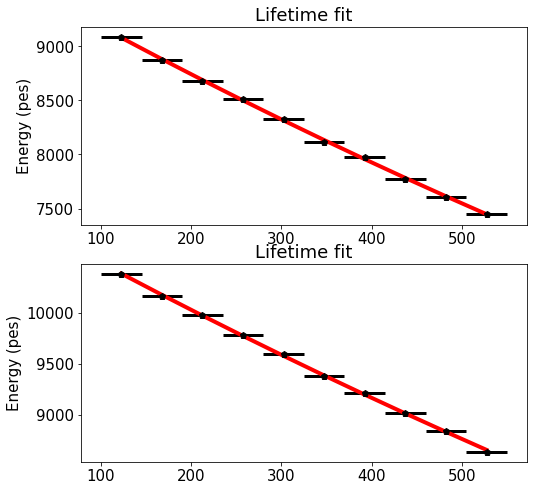

In [92]:
KF = krf.lifetimes_in_XYRange(kdst2.fid, krNBins2, krBins2, krRanges2, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9681.348572720117 +-20.000623204648356 
 LT      = -2048.5871486085143 +-25.595831784921753 
 chi2    = 1.6792495878199087 
 E (z=0) = 10932.911843001688 +-10.152096348091408 
 LT      = -2525.1142233094256 +-17.37384624377452 
 chi2    = 1.1806289047403034 


[None, None]

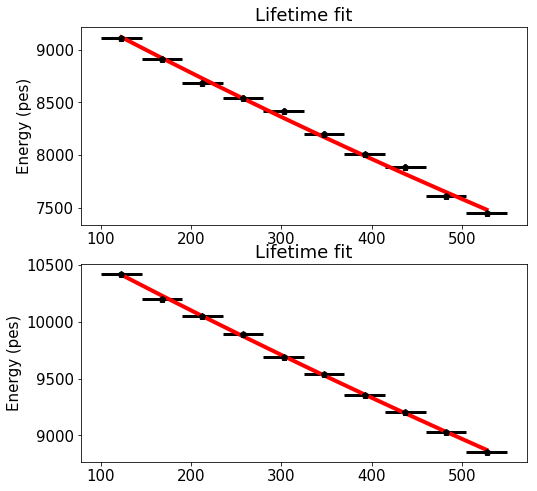

In [93]:
KF = krf.lifetimes_in_XYRange(kdst3.fid, krNBins3, krBins3, krRanges3, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

In [94]:
KF

[KrFit(par=array([ 9681.34857272, -2048.58714861]), err=array([ 20.0006232 ,  25.59583178]), chi2=1.6792495878199087),
 KrFit(par=array([ 10932.911843  ,  -2525.11422331]), err=array([ 10.15209635,  17.37384624]), chi2=1.1806289047403034)]

In [95]:
es_low = KF[0].par[0]
esu_low = KF[0].err[0]
es_hig = KF[1].par[0]
esu_hig = KF[1].err[0]
lt_low = np.abs(KF[0].par[1])
ltu_low = np.abs(KF[0].err[1])
lt_hig = np.abs(KF[1].par[1])
ltu_hig = np.abs(KF[1].err[1])
print(f"LOW:  es +- err = {es_low} +- {esu_low}")
print(f"High:  es +- err = {es_hig} +- {esu_hig}")
print(f"LOW:  lt +- err = {lt_low} +- {ltu_low}")
print(f"High:  lt +- err = {lt_hig} +- {ltu_hig}")

LOW:  es +- err = 9681.348572720117 +- 20.000623204648356
High:  es +- err = 10932.911843001688 +- 10.152096348091408
LOW:  lt +- err = 2048.5871486085143 +- 25.595831784921753
High:  lt +- err = 2525.1142233094256 +- 17.37384624377452


### Time profile of LT in the fiducial

In [96]:
fits = krf.lifetimes_in_TRange(kdst.fid, krNBins, krBins, krRanges,  TL=krTimes.TL)

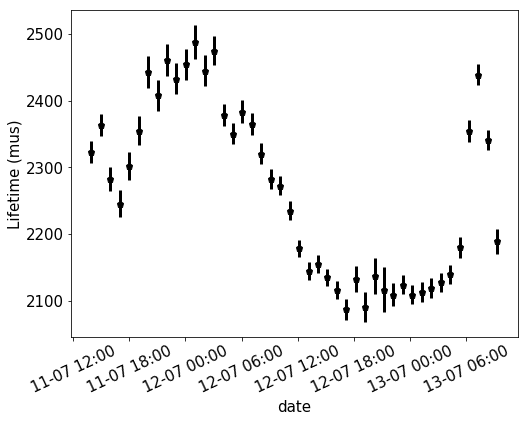

In [97]:
krp.plot_lifetime_T(fits, krTimes.timeStamps)

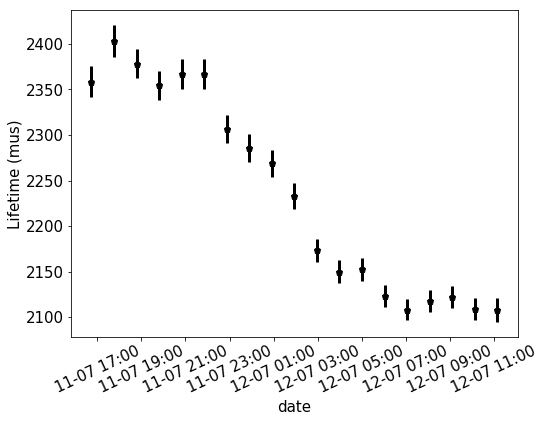

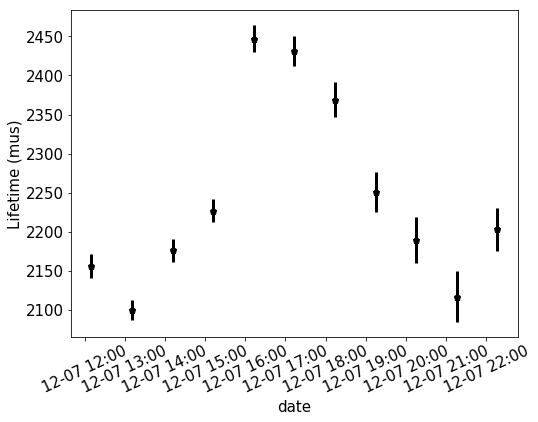

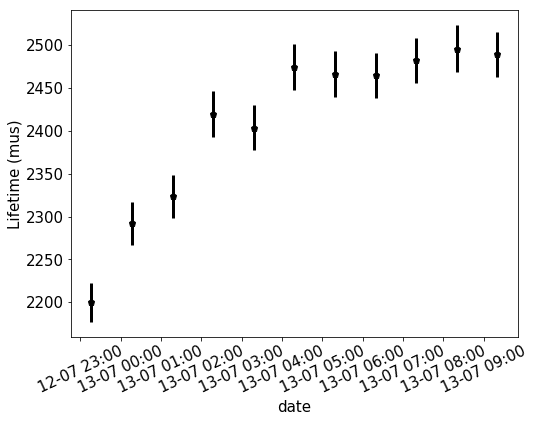

In [101]:
fits = krf.lifetimes_in_TRange(kdst1.fid, krNBins1, krBins1, krRanges1,  TL=krTimes1.TL)
krp.plot_lifetime_T(fits, krTimes1.timeStamps)

fits = krf.lifetimes_in_TRange(kdst2.fid, krNBins2, krBins2, krRanges2,  TL=krTimes2.TL)
krp.plot_lifetime_T(fits, krTimes2.timeStamps)

fits = krf.lifetimes_in_TRange(kdst3.fid, krNBins3, krBins3, krRanges3,  TL=krTimes3.TL)
krp.plot_lifetime_T(fits, krTimes3.timeStamps)
    


### Compute lifetime maps

In [131]:
def lifetime_map(kdst, krnbins, krbins, krranges):
    krfs = krf.fit_lifetime_slices(kdst.full, krnbins, krbins, krranges, fit_var = "E", min_entries=100)
    Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
    Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
    ELT        = to_relative(ELT_abs, percentual=True)
    
    invalid = ~valid
    mask = valid


    print(f" fraction of valid fits ={np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])}")
    El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
    Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

    print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
    print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
    print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
    print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')
    n_sigma  = 2.5
    u_sigma  = 2.5
    kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


    print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
    print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
    print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
    print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")
    
    Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value ,     es_low), 
                     np.where(valid, Escale_abs.uncertainty,       esu_low ))

    ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , lt_low), 
                  np.where(valid,  ELT_abs.uncertainty,    ltu_low))
    
    Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
    ELT_corr        = to_relative(ELT_abs_corr, percentual=True)
    
    #krp.figsize("L")
    #krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=valid)
                         
  
    krp.figsize("L")
    krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY,  cmap="jet", mask=None)

    krp.figsize("S")
    krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
            title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))
    fig = plt.figure(figsize=(8,6))
  
    #ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
    #*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
     #                   vmin = 0, vmax = 4,
      #                  cmap = default_cmap,
      #                  new_figure = False)
    #cb.set_label("$\chi^2$")
    #labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 fraction of valid fits =0.801875
Lifetime value           : mu +- std =2045.8358883709002 +- 352.2756599573098
Lifetime uncertainty     : mu +- std =2.109387022354287 +- 1.8177030178555433
Energy scale value       : mu +- std =9886.87072913951 +- 1404.128705407716
Energy scale uncertainty : mu +- std =0.3646550667598103 +- 0.4575652887614798
 Energy scale (E): E_min = 6376.548965620219; E_max = 13397.1924926588
 Lifetime (ELT): ELT_min = 1165.1467384776256; ELT_max = 2926.525038264175
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 1.5085682886635097
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 6.653644566993146


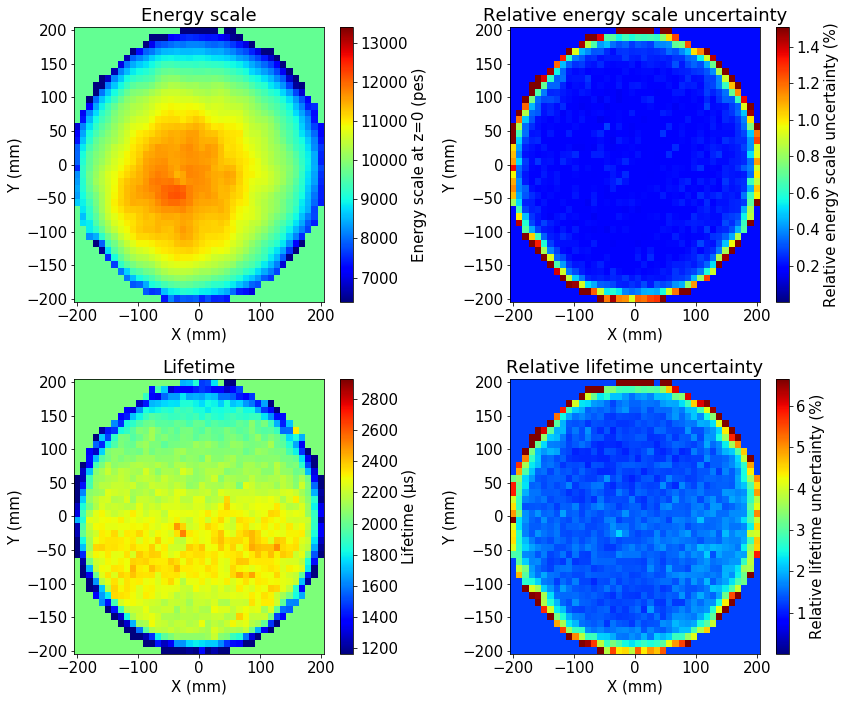

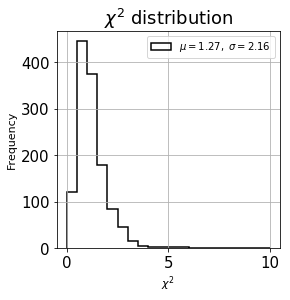

In [132]:
lifetime_map(kdst1, krNBins1, krBins1, krRanges1)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 fraction of valid fits =0.78875
Lifetime value           : mu +- std =2067.4121608345167 +- 293.6093756097615
Lifetime uncertainty     : mu +- std =3.7938538946252933 +- 2.6849338582069624
Energy scale value       : mu +- std =10023.746702187987 +- 1347.482457970497
Energy scale uncertainty : mu +- std =0.6361157862003579 +- 0.6017913511259125
 Energy scale (E): E_min = 6655.040557261745; E_max = 13392.45284711423
 Lifetime (ELT): ELT_min = 1333.3887218101129; ELT_max = 2801.435599858921
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 2.1405941640151394
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 10.506188540142698


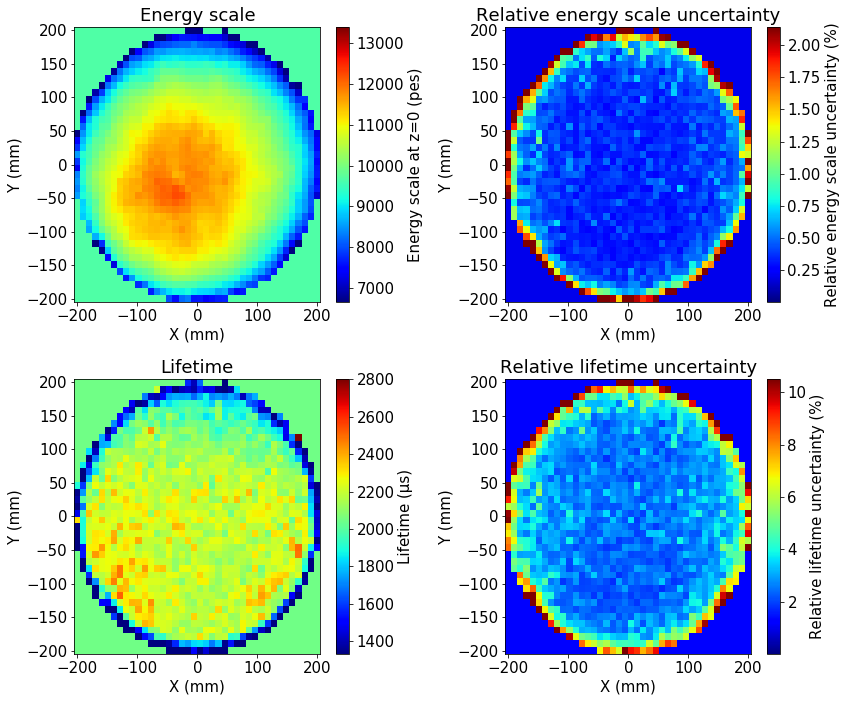

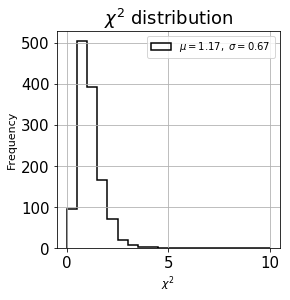

In [133]:
lifetime_map(kdst2, krNBins2, krBins2, krRanges2)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 fraction of valid fits =0.7925
Lifetime value           : mu +- std =2148.7328730508557 +- 395.8836843531519
Lifetime uncertainty     : mu +- std =5.807538091890385 +- 2.6005295813604934
Energy scale value       : mu +- std =10072.921897849312 +- 1297.1791269960772
Energy scale uncertainty : mu +- std =1.0291235634654878 +- 0.6408057403541457
 Energy scale (E): E_min = 6829.9740803591185; E_max = 13315.869715339504
 Lifetime (ELT): ELT_min = 1159.023662167976; ELT_max = 3138.4420839337354
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 2.631137914350852
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 12.308862045291619


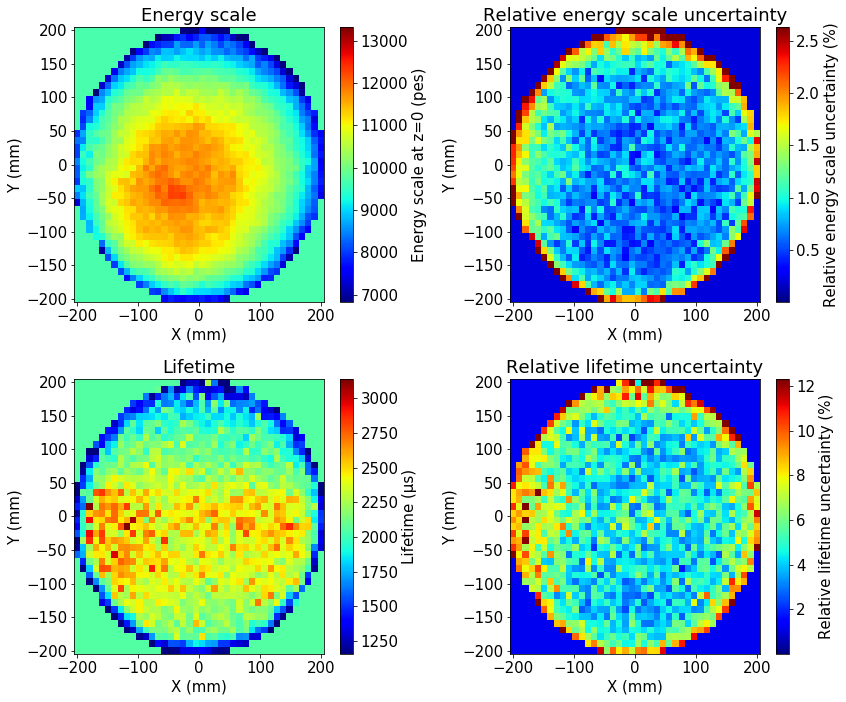

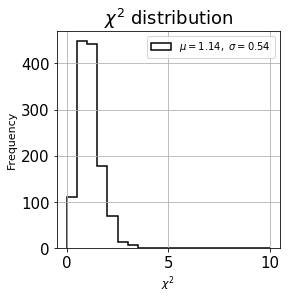

In [134]:
lifetime_map(kdst3, krNBins3, krBins3, krRanges3)

In [59]:
gvalid   = np.zeros((krNBins.XY,krNBins.XY), dtype=bool)

In [60]:
def gfid(gvalid):
    for i in range(krNBins.XY):
        for j in range(krNBins.XY):
            if  np.sqrt(krBins.cXY[i]**2 + krBins.cXY[j]**2) < krRanges.XY[1] :
                    gvalid[i, j] = True

In [61]:
gfid(gvalid)

In [62]:
np.count_nonzero(gvalid) / (gvalid.shape[0] * gvalid.shape[1])

0.79

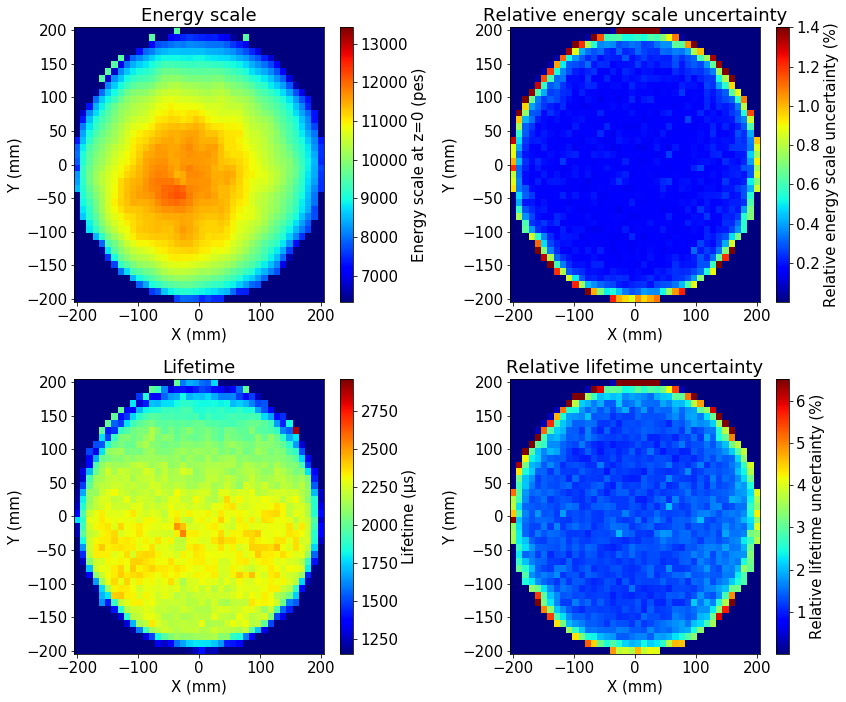

In [63]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=gvalid)